# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_38', 'ORACLE.run1_44', 'ORACLE.run1_8', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_26', 'ORACLE.run1_14', 'ORACLE.run1_50'}


{'ORACLE.run2_44', 'ORACLE.run2_50', 'ORACLE.run2_26', 'ORACLE.run2_8', 'ORACLE.run2_32', 'ORACLE.run2_38', 'ORACLE.run2_14', 'ORACLE.run2_20'}


tensor([[[-0.0924,  1.1552, -0.1109,  ..., -0.9518, -0.2588, -0.5545],
         [-0.6376, -0.2957,  1.0535,  ...,  0.2403, -1.4139, -0.4713]],

        [[-0.4449,  0.6767,  0.5469,  ..., -1.2421, -1.1679, -0.1112],
         [-1.1216, -0.3152,  1.1030,  ...,  0.4078, -0.1483,  1.2050]],

        [[ 0.6507, -0.3532, -0.7623,  ...,  0.7901,  1.3665,  0.3254],
         [ 0.8273,  0.6786, -0.8831,  ..., -0.7530,  0.4648, -1.1527]],

        ...,

        [[ 0.9828, -0.2394, -1.1718,  ...,  0.6363,  0.9828, -0.6489],
         [ 0.5544,  0.7119, -0.3717,  ..., -0.9702, -0.6111, -1.1214]],

        [[ 0.0252, -0.9847,  0.2840,  ...,  0.8963,  0.4671,  1.0667],
         [ 0.7890,  0.4229, -1.1298,  ..., -0.1199,  1.2624, -0.2272]],

        [[ 0.4796,  0.3281, -0.7194,  ..., -0.4544,  1.2306,  1.0223],
         [-0.4102,  1.1043, -0.0316,  ..., -1.0728, -0.0568, -0.2461]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 44.4843, train_label_loss: 3.1675, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2886.2902, train_label_loss: 1.4065, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2921.3272, train_label_loss: 0.7499, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2916.4555, train_label_loss: 0.7491, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2888.6415, train_label_loss: 0.9575, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2905.0634, train_label_loss: 0.8728, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2905.3582, train_label_loss: 0.7361, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2910.3599, train_label_loss: 0.4696, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2901.4340, train_label_loss: 0.8406, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2901.1729, train_label_loss: 0.5711, 


epoch: 1, source_val_acc_label: 0.6142, target_val_acc_label: 0.6127, source_val_label_loss: 24.2043, target_val_label_loss: 29.0524, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.3481, train_label_loss: 20.7856, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3073.4157, train_label_loss: 0.4383, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2894.4195, train_label_loss: 0.3769, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2934.8734, train_label_loss: 1.0877, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2937.6843, train_label_loss: 0.8993, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2941.8672, train_label_loss: 0.4903, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2928.2419, train_label_loss: 1.0150, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2906.7010, train_label_loss: 0.6799, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2946.3036, train_label_loss: 0.6678, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2956.5169, train_label_loss: 0.3942, 


epoch: 2, source_val_acc_label: 0.7860, target_val_acc_label: 0.7796, source_val_label_loss: 0.5960, target_val_label_loss: 0.6486, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.7541, train_label_loss: 0.7477, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3247.1238, train_label_loss: 0.3352, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3292.2434, train_label_loss: 0.4804, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3267.6754, train_label_loss: 0.2625, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3255.7042, train_label_loss: 0.4495, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3285.7749, train_label_loss: 0.9016, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3282.7432, train_label_loss: 0.7243, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3254.1993, train_label_loss: 0.3175, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3173.2817, train_label_loss: 0.4237, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3231.5983, train_label_loss: 0.1610, 


epoch: 3, source_val_acc_label: 0.8012, target_val_acc_label: 0.7946, source_val_label_loss: 0.5360, target_val_label_loss: 0.5966, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.7491, train_label_loss: 0.4782, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3177.0742, train_label_loss: 0.1952, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3140.4185, train_label_loss: 0.8422, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3207.0259, train_label_loss: 0.5839, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3253.6923, train_label_loss: 0.6447, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3309.2575, train_label_loss: 0.3687, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3303.5673, train_label_loss: 0.8057, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3299.2262, train_label_loss: 0.5208, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3312.4620, train_label_loss: 0.2590, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3313.7283, train_label_loss: 0.3403, 


epoch: 4, source_val_acc_label: 0.8319, target_val_acc_label: 0.8168, source_val_label_loss: 0.4810, target_val_label_loss: 0.5434, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.8963, train_label_loss: 0.0865, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3278.6869, train_label_loss: 0.2582, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3309.7507, train_label_loss: 0.7896, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3301.0948, train_label_loss: 0.6884, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3305.5936, train_label_loss: 0.3847, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3297.7913, train_label_loss: 0.1306, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3306.6550, train_label_loss: 0.4501, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3298.9559, train_label_loss: 0.2112, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3309.6599, train_label_loss: 0.5343, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3319.0722, train_label_loss: 0.3523, 


epoch: 5, source_val_acc_label: 0.8476, target_val_acc_label: 0.8369, source_val_label_loss: 0.4313, target_val_label_loss: 0.4902, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.8916, train_label_loss: 0.3434, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3220.1366, train_label_loss: 0.5088, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3319.5650, train_label_loss: 0.4333, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3329.8128, train_label_loss: 0.3748, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3320.4490, train_label_loss: 0.2833, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3327.4844, train_label_loss: 0.1162, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3332.2188, train_label_loss: 0.4465, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3322.1801, train_label_loss: 0.3257, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3329.6066, train_label_loss: 0.4000, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3315.9317, train_label_loss: 0.1514, 


epoch: 6, source_val_acc_label: 0.8700, target_val_acc_label: 0.8561, source_val_label_loss: 0.3782, target_val_label_loss: 0.4363, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.8986, train_label_loss: 0.1028, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3280.3106, train_label_loss: 0.5985, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3299.6700, train_label_loss: 0.2691, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3308.0187, train_label_loss: 0.3743, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3250.0009, train_label_loss: 0.5099, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3202.5239, train_label_loss: 0.8230, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3250.6332, train_label_loss: 0.2225, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3229.9694, train_label_loss: 0.3699, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3249.4102, train_label_loss: 0.2927, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3263.3958, train_label_loss: 0.2025, 


epoch: 7, source_val_acc_label: 0.8628, target_val_acc_label: 0.8505, source_val_label_loss: 0.3793, target_val_label_loss: 0.4461, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.8427, train_label_loss: 0.4907, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3233.6989, train_label_loss: 0.4956, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3242.8665, train_label_loss: 0.4457, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3249.8665, train_label_loss: 0.1762, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2984.4235, train_label_loss: 0.0821, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3103.8939, train_label_loss: 0.5009, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3242.5235, train_label_loss: 0.5427, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3223.8895, train_label_loss: 0.3269, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3205.7731, train_label_loss: 0.2919, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3238.7813, train_label_loss: 0.3216, 


epoch: 8, source_val_acc_label: 0.8786, target_val_acc_label: 0.8618, source_val_label_loss: 0.3451, target_val_label_loss: 0.4223, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.7392, train_label_loss: 0.1951, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3152.7668, train_label_loss: 0.6043, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3186.9481, train_label_loss: 0.5141, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3150.1356, train_label_loss: 0.3116, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3136.0720, train_label_loss: 0.2524, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3153.3884, train_label_loss: 0.5479, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3184.4940, train_label_loss: 0.4784, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3212.4722, train_label_loss: 0.3079, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3118.0384, train_label_loss: 0.3260, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3148.1141, train_label_loss: 0.0515, 


epoch: 9, source_val_acc_label: 0.8786, target_val_acc_label: 0.8592, source_val_label_loss: 0.3418, target_val_label_loss: 0.4232, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.7139, train_label_loss: 0.3873, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3242.1661, train_label_loss: 0.2373, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3238.8122, train_label_loss: 0.4103, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3217.9124, train_label_loss: 0.3029, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3239.9172, train_label_loss: 0.1915, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3268.7042, train_label_loss: 0.2338, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3223.1473, train_label_loss: 0.2827, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3158.4688, train_label_loss: 0.2631, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3270.4283, train_label_loss: 0.3561, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3293.0247, train_label_loss: 0.0543, 


epoch: 10, source_val_acc_label: 0.8915, target_val_acc_label: 0.8697, source_val_label_loss: 0.3057, target_val_label_loss: 0.3971, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.9008, train_label_loss: 0.2382, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3278.1048, train_label_loss: 0.3846, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3306.6266, train_label_loss: 0.3809, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3312.5597, train_label_loss: 0.2818, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3299.7047, train_label_loss: 0.5872, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3309.1178, train_label_loss: 0.3195, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3284.5128, train_label_loss: 0.3122, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3278.0731, train_label_loss: 0.1900, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3308.1102, train_label_loss: 0.4935, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3312.1694, train_label_loss: 0.1463, 


epoch: 11, source_val_acc_label: 0.8930, target_val_acc_label: 0.8715, source_val_label_loss: 0.3017, target_val_label_loss: 0.3897, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.9124, train_label_loss: 0.5374, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3279.7108, train_label_loss: 0.4214, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3306.6088, train_label_loss: 0.1016, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3293.3444, train_label_loss: 0.5605, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3244.8959, train_label_loss: 0.0874, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3319.1149, train_label_loss: 0.2740, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3336.1571, train_label_loss: 0.4469, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3322.3788, train_label_loss: 0.1755, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3335.9251, train_label_loss: 0.0498, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3328.0618, train_label_loss: 0.1092, 


epoch: 12, source_val_acc_label: 0.8964, target_val_acc_label: 0.8744, source_val_label_loss: 0.2927, target_val_label_loss: 0.3919, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.9307, train_label_loss: 0.3974, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3293.7709, train_label_loss: 0.3413, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3312.4587, train_label_loss: 0.2098, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3336.3202, train_label_loss: 0.2387, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3310.8645, train_label_loss: 0.0888, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3318.7829, train_label_loss: 0.5104, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3326.2146, train_label_loss: 0.5561, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3318.7933, train_label_loss: 0.0201, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3332.8995, train_label_loss: 0.1944, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3328.7036, train_label_loss: 0.2077, 


epoch: 13, source_val_acc_label: 0.8966, target_val_acc_label: 0.8723, source_val_label_loss: 0.2904, target_val_label_loss: 0.3883, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.9020, train_label_loss: 0.2512, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3317.5702, train_label_loss: 0.3351, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3328.8781, train_label_loss: 0.2457, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3335.8363, train_label_loss: 0.1140, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3317.0268, train_label_loss: 0.2355, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3311.9362, train_label_loss: 0.1638, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3303.0865, train_label_loss: 0.6978, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3309.5410, train_label_loss: 0.1795, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3316.8789, train_label_loss: 0.0897, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3329.5131, train_label_loss: 0.0663, 


epoch: 14, source_val_acc_label: 0.8922, target_val_acc_label: 0.8718, source_val_label_loss: 0.2969, target_val_label_loss: 0.3953, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.9178, train_label_loss: 0.0343, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3275.9960, train_label_loss: 0.1688, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3314.9065, train_label_loss: 0.1332, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3325.7072, train_label_loss: 0.2242, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3321.7177, train_label_loss: 0.1990, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3327.0157, train_label_loss: 0.1572, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3328.5601, train_label_loss: 0.3437, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3317.9785, train_label_loss: 0.3735, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3321.7170, train_label_loss: 0.0670, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3330.3806, train_label_loss: 0.2019, 


epoch: 15, source_val_acc_label: 0.8932, target_val_acc_label: 0.8691, source_val_label_loss: 0.2969, target_val_label_loss: 0.3935, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.9204, train_label_loss: 0.2562, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3303.7310, train_label_loss: 0.0898, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3335.1261, train_label_loss: 0.0522, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3330.4104, train_label_loss: 0.1319, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3314.7157, train_label_loss: 0.1851, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3327.3622, train_label_loss: 0.2642, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3329.3956, train_label_loss: 0.4155, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3320.4488, train_label_loss: 0.1731, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3320.3645, train_label_loss: 0.3634, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3317.8179, train_label_loss: 0.0812, 


epoch: 16, source_val_acc_label: 0.8780, target_val_acc_label: 0.8549, source_val_label_loss: 0.3356, target_val_label_loss: 0.4338, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.9285, train_label_loss: 0.0288, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3291.8475, train_label_loss: 0.1885, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3319.0071, train_label_loss: 0.0532, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3321.5696, train_label_loss: 0.3263, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3317.1496, train_label_loss: 0.2328, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3323.4916, train_label_loss: 0.3482, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3328.3829, train_label_loss: 0.4112, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3320.9039, train_label_loss: 0.1538, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3320.8393, train_label_loss: 0.3474, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3335.1965, train_label_loss: 0.1245, 


epoch: 17, source_val_acc_label: 0.9002, target_val_acc_label: 0.8751, source_val_label_loss: 0.2884, target_val_label_loss: 0.3982, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

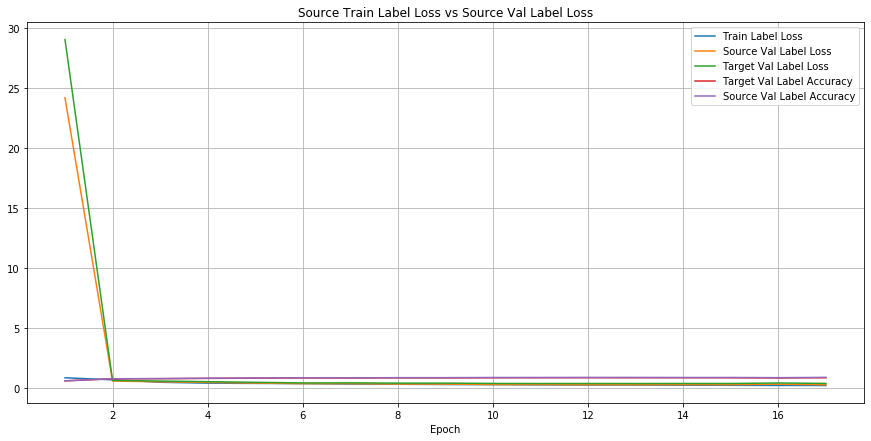

In [25]:
ax = get_loss_curve(experiment)
plt.show()

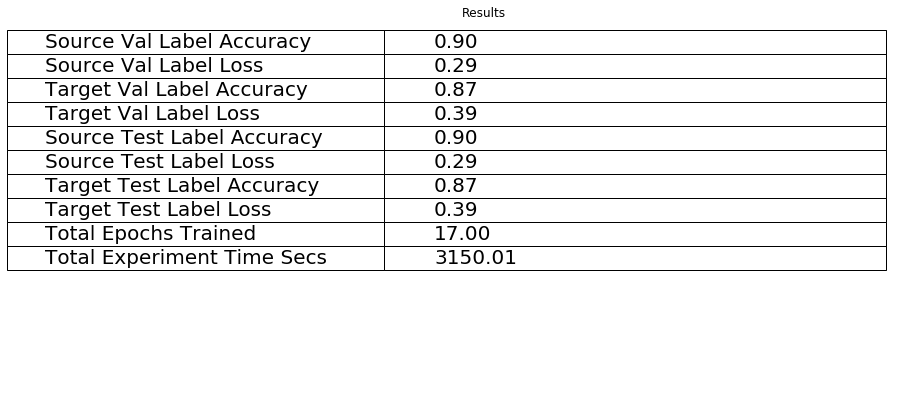

In [26]:
get_results_table(experiment)

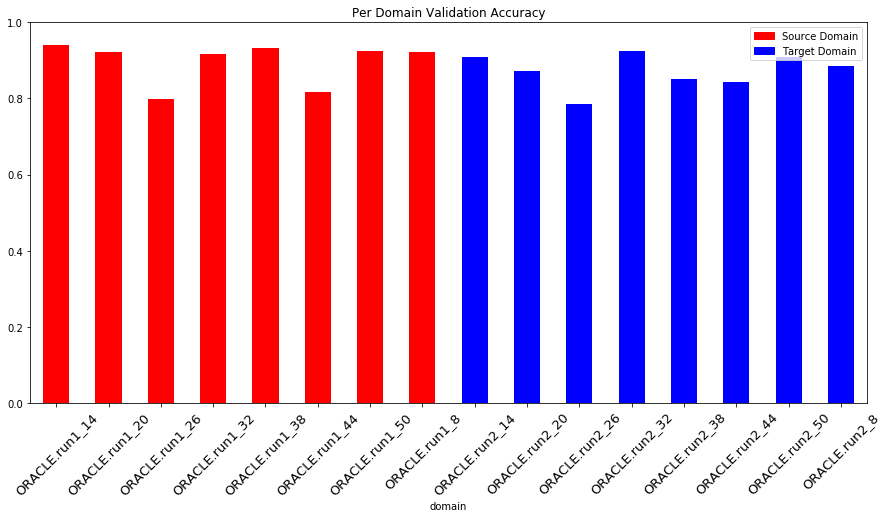

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.898046875 Target Test Label Accuracy: 0.8747395833333333
Source Val Label Accuracy: 0.8966145833333333 Target Val Label Accuracy: 0.872265625


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1_oracle.run1-oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480